In [1]:
import requests
import pandas

In [2]:
BASE_URL = "https://opendata.cbs.nl/ODataApi/OData/70072NED"

def df_request(url: str) -> pandas.DataFrame:
    """ JSON url -> DataFrame """
    resp = requests.get(url)
    assert(resp.status_code == 200)
    data = resp.json()['value']
    return pandas.DataFrame.from_records(data)

In [3]:
perioden = df_request(f"{BASE_URL}/Perioden")

Load data from *Regionale kerncijfers Nederland* statline table by CBS.

Note that income data is only available up to 2015.

This table can also be used to link between differing CBS region codes if needed since they are all included. Alternatively, use the CBS zip code table if you need these as well.

In [4]:
def data_for_year(year: str, columns=['Vrouwen_3', 'Mannen_2', 'RegioS', 'TotaalParticuliereHuishoudens_148']) -> pandas.DataFrame:
    """
    Select data from the correct CBS table and filter the columns.
    
    Keep columns on:
      * corrected income (for household size) = TotaalParticuliereHuishoudens_148
      * Number of inhabitants by gender
        * Female = Vrouwen_3
        * Male = Mannen_2
      * region code ("CBS gemeente code") = RegioS
    """
    # Select the correct Period code:
    pfy = perioden[perioden['Title'] == str(year)]
    assert(pfy.shape[0] == 1)
    period_code = pfy.iloc[0]['Key']
    select_str = ','.join(columns)
    data = df_request(f"{BASE_URL}/TypedDataSet?$filter=Perioden eq '{period_code}'&$select={select_str}")
    # Filter gemeente codes
    data = data[data['RegioS'].str.startswith('GM')]
    # Strip 'GM' prefix, parse as integer
    data['RegioS'] = data['RegioS'].str.replace('GM', '').astype(int)
    data = data.rename(index=str, columns={
        'TotaalParticuliereHuishoudens_148': 'corrected_income',
        'Mannen_2': 'male',
        'Vrouwen_3': 'female'
    })
    return data.set_index('RegioS')

Load RIVM (Rijksinstituut voor Volksgezondheid en Milieu) [levensverwachting bij geboorte per gemeente](https://www.volksgezondheidenzorg.info/onderwerp/levensverwachting/regionaal-internationaal/bij-geboorte#node-levensverwachting-bij-geboorte-gemeente) data.

This CSV sheet is in the regular Excel/Windows format and uses gemeenten from 2017. This means that some gemeenten in the dataset will not yet exist in the income data. This will drop 12 rows (4 gemeenten).

When interpreting this data, beware of the bias "insensitivity to sample size". Small samples have an inherently larger variance, large outliers may be caused by this effect.

In [5]:
def life_expectancy_data() -> pandas.DataFrame:
    """Read RIVM life expectancy data, set CBS gemeente (2017!) code as column"""
    with open('data/do1316lvgem_3.csv', 'r', encoding='Windows-1252') as csvfile:
        life_expect_data = pandas.read_csv(csvfile, sep=';',  quotechar="\"", decimal=",")
        life_expect_data = life_expect_data.rename(index=str, columns={
            'Geslacht': 'gender',
            'Bij geboorte': 'expectancy_birth',
            'Bij 65 jaar': 'expectancy_aged_65',
            'Gemeente': 'gemeente',
            'Bij geboorte (afwijking tov NL)': 'expectancy_birth_confidence',
            'Bij 65 jaar (afwijking tov NL)': 'expectancy_65_confidence',            
        })
        # Map values from dutch to english
        life_expect_data['gender'] = life_expect_data['gender'].map({
            'Mannen': 'male',
            'Vrouwen': 'female',
            'Totaal': 'total',
        })
        return life_expect_data.set_index('id')

In [6]:
# Join the two tables and drop Not a Number values (drops 4 gemeenten)
expectancy_income_population = life_expectancy_data().join(data_for_year(2015)).dropna()
def inhabitants_by_geslacht(row) -> int:
    if row['gender'] == 'total':
        return row['male'] + row['female']
    elif row['gender'] == 'male':
        return row['male']
    elif row['gender'] == 'female':
        return row['female']
    assert(False)
# Now create 'number of inhabitants' column based on Geslacht column
expectancy_income_population['population'] = expectancy_income_population.apply(inhabitants_by_geslacht, axis=1)
expectancy_income_population = expectancy_income_population.filter(items=[
    'gender', 'expectancy_birth', 'expectancy_aged_65',
    'population', 'corrected_income', 'gemeente', 'expectancy_65_confidence', 'expectancy_birth_confidence'])

In [7]:
expectancy_income_population.to_json('out/life_expectancy_income_population.json', orient='records')

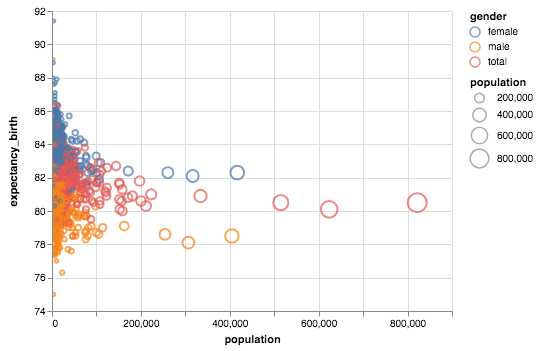

In [9]:
# Not that interesting as a visualization
import altair as alt

alt.Chart(expectancy_income_population).mark_point().encode(
    alt.X('population:Q', scale=alt.Scale(zero=False)),
    alt.Y('expectancy_birth:Q', scale=alt.Scale(zero=False)),
    color='gender:N',
    size=alt.Size('population:Q', scale=alt.Scale(zero=False)),
    tooltip='gemeente',
).interactive()